In [1]:
!pip install vit-keras

  Created wheel for validators: filename=validators-0.19.0-py3-none-any.whl size=19553 sha256=cd36c848f7d131be30bd33c45f616d18bf4cf0813eb81bf93e60ce01365ca0dd
  Stored in directory: /root/.cache/pip/wheels/fe/5d/69/ff53a908b9f14fb7730a58fdede0fac4cdc99ef3624ec76d05
Successfully built validators


In [2]:
# Import Libraries
import warnings
warnings.filterwarnings('ignore')
import time
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [3]:
# 모델의 reproducibility를 위해 학습 환경 및 random seed 고정
import numpy as np
import tensorflow as tf
import random

seed_num = 256
np.random.seed(seed_num)
random.seed(seed_num)
tf.random.set_seed(seed_num)

from keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads = 1,
                                        inter_op_parallelism_threads = 1)
sess = tf.compat.v1.Session(graph = tf.compat.v1.get_default_graph(), config = session_conf)
K.set_session(sess)

In [4]:
#모델 라이브러리 가져오기 
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
import tensorflow as tf
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.preprocessing.image import ImageDataGenerator


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
x_train = np.load('/content/drive/Shareddrives/2022-1 KUBIG 음악추천시스템/melspectogram.npy')

In [18]:
x_train[0].shape

(128, 2584)

In [19]:
target = []
for i in range(200):
  target.append(0)
for i in range(200):
  target.append(1)
for i in range(200):
  target.append(2)
for i in range(200):
  target.append(3)
for i in range(200):
  target.append(4)

In [20]:
y_train = np.array(target)

In [21]:
import cv2
cv2.resize(x_train[0], (224, 224), interpolation = cv2.INTER_LANCZOS4).shape
new = []
for i in range(1000):
  new.append(cv2.resize(x_train[i], (224, 224), interpolation = cv2.INTER_LANCZOS4))

In [22]:
new2 = []
for i in range(1000):
  new2.append(np.array([new[i], new[i], new[i]]))

In [23]:
x_train = np.array(new2)

In [24]:
x_train.shape

(1000, 3, 224, 224)

In [25]:
x_train = np.swapaxes(np.swapaxes(x_train, 1, 2), 2, 3)

In [26]:
x_train.shape

(1000, 224, 224, 3)

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, random_state = 256, test_size = 0.2)

In [29]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 14.0 MB/s 


In [31]:
from vit_keras import vit, utils, visualize

image_size = 224

model = vit.vit_b16(
    image_size=image_size,
    activation='relu',
    pretrained=True,
    include_top=True,
    pretrained_top=False,
    classes=5
)

347512832/347502902 [==============================] - 3s 0us/step


In [32]:
for layer in model.layers[:-1]:
    layer.trainable = False

In [33]:
# 모델 컴파일
model.compile(optimizer ='adamax',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

print('Model Details are : ')
print(model.summary())

Model Details are : 
Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape_1 (Reshape)         (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input   (None, 197, 768)         151296    
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 197, 768),       7087872   
 (TransformerBlock)           (None, 1

In [34]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

kfold = 5
skf = StratifiedKFold(n_splits = kfold, shuffle = True, random_state = 256)

In [35]:
from keras.callbacks import ModelCheckpoint, EarlyStopping  

In [36]:
testpred = []
testprob = []

for i, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
    
    print('[Fold %d/%d]' % (i + 1, kfold))
    
    
    trainx, validx = X_train[train_index], X_train[val_index]
    trainy, validy = y_train[train_index], y_train[val_index]

 
    callbacks_list = [  
      ModelCheckpoint('/content/drive/MyDrive/musicrecommendation_resent.h5', monitor='val_accuracy', mode='max', verbose = 1, save_best_only = True),
      EarlyStopping(patience=8, verbose = 1),
      ReduceLROnPlateau(patience=4, verbose=1)
    ]  

    ThisModel = model.fit(trainx, trainy, validation_data = (validx, validy), batch_size=32, epochs=100, callbacks=callbacks_list, verbose=1)

    pred = np.argmax(model.predict(X_test), axis = 1)
    testpred.append(pred)
    prob = model.predict(X_test)
    testprob.append(prob)

[Fold 1/5]
Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 5.9686 - accuracy: 0.2062
Epoch 1: val_accuracy improved from -inf to 0.24375, saving model to /content/drive/MyDrive/musicrecommendation_resent.h5
20/20 [==============================] - 59s 2s/step - loss: 5.9686 - accuracy: 0.2062 - val_loss: 4.4678 - val_accuracy: 0.2438 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 4.6115 - accuracy: 0.2219
Epoch 2: val_accuracy improved from 0.24375 to 0.25625, saving model to /content/drive/MyDrive/musicrecommendation_resent.h5
20/20 [==============================] - 13s 639ms/step - loss: 4.6115 - accuracy: 0.2219 - val_loss: 4.5019 - val_accuracy: 0.2562 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 4.4764 - accuracy: 0.2250
Epoch 3: val_accuracy did not improve from 0.25625
20/20 [==============================] - 11s 578ms/step - loss: 4.4764 - accuracy: 0.2250 - val_loss: 4.5042 - val_accu

In [37]:
testpred

[array([1, 1, 3, 3, 3, 1, 3, 4, 1, 3, 4, 2, 3, 4, 3, 1, 2, 3, 1, 1, 3, 4,
        2, 1, 2, 4, 4, 1, 1, 3, 1, 3, 1, 4, 3, 3, 4, 3, 3, 4, 3, 3, 4, 4,
        1, 1, 1, 4, 4, 3, 4, 1, 3, 4, 1, 3, 3, 4, 4, 4, 3, 4, 1, 1, 4, 3,
        3, 3, 3, 1, 1, 4, 3, 2, 1, 2, 4, 4, 4, 4, 4, 3, 4, 3, 4, 1, 4, 4,
        4, 1, 3, 1, 4, 4, 4, 3, 2, 4, 3, 4, 1, 3, 1, 3, 3, 3, 3, 1, 3, 4,
        4, 1, 1, 4, 4, 1, 3, 2, 3, 4, 1, 4, 4, 3, 4, 4, 1, 3, 1, 3, 1, 2,
        3, 1, 1, 1, 3, 4, 3, 3, 1, 3, 1, 4, 3, 3, 3, 1, 3, 3, 4, 1, 4, 4,
        3, 3, 1, 4, 1, 3, 1, 1, 4, 1, 4, 3, 1, 3, 3, 4, 3, 3, 1, 3, 4, 3,
        3, 3, 2, 3, 3, 1, 2, 2, 3, 1, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 4, 2,
        1, 3]),
 array([1, 1, 3, 3, 3, 1, 3, 4, 1, 3, 4, 2, 3, 4, 3, 1, 2, 3, 1, 1, 3, 4,
        2, 1, 2, 4, 4, 1, 1, 3, 1, 3, 1, 4, 3, 3, 4, 3, 3, 4, 3, 3, 4, 4,
        1, 1, 1, 4, 4, 3, 4, 1, 3, 4, 1, 3, 3, 4, 4, 4, 3, 4, 1, 1, 4, 3,
        3, 3, 3, 1, 1, 4, 3, 2, 1, 2, 4, 4, 4, 4, 4, 3, 4, 3, 4, 1, 4, 4,
        4, 1, 3, 1, 4,

In [38]:
testprob

[array([[0.        , 2.1462562 , 1.6977339 , 1.9907478 , 1.4109792 ],
        [0.        , 1.9347636 , 1.6319284 , 1.7789779 , 1.7578249 ],
        [0.        , 1.4879873 , 1.812677  , 2.487185  , 1.6808468 ],
        [0.        , 1.4321347 , 1.228217  , 2.066533  , 1.2903821 ],
        [0.        , 1.5373479 , 1.5091401 , 1.8813927 , 1.5361578 ],
        [0.        , 2.4519775 , 1.6390301 , 2.2843146 , 2.3011916 ],
        [0.        , 1.8016661 , 1.6689973 , 2.016664  , 1.3200122 ],
        [0.        , 1.590202  , 1.4048264 , 1.9339197 , 2.2060297 ],
        [0.        , 2.666477  , 1.6887699 , 2.5684533 , 1.2369056 ],
        [0.        , 1.7414595 , 1.411092  , 1.7577217 , 1.6686136 ],
        [0.        , 1.7822555 , 2.3229444 , 1.5556896 , 2.6654377 ],
        [0.        , 1.7705418 , 1.9660147 , 1.7977077 , 1.322538  ],
        [0.        , 1.7036117 , 1.5219966 , 1.971883  , 1.7780703 ],
        [0.        , 1.3161361 , 1.6649672 , 1.5491896 , 1.8123468 ],
        [0.        ,

In [39]:
for i in range(5):
  sum = 0
  sum_list = []
  for j in range(len(testpred[i])):
    if testpred[i][j] == y_test[j]:
      sum = sum + 1
  print(sum / len(testpred[1]) * 100)
  sum_list.append(sum / len(testpred[1]) * 100)

25.5
25.5
25.5
25.5
25.5


In [40]:
np.mean(sum_list)

25.5

In [41]:
from sklearn.metrics import accuracy_score, classification_report

In [42]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [43]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a treshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [44]:
def plot_roc_curve_blue(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax, ci=None, color='skyblue', alpha = 0.08)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'black', ax = ax, alpha = 0.05, linestyle='--')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [45]:
def plot_roc_curve_red(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax, ci=None, color='red', alpha = 0.08)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'black', ax = ax, alpha = 0.05, linestyle='--')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [46]:
def plot_roc_curve_red_2(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax, ci=None, color='red', alpha = 1)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [47]:
classes = [0, 1, 2, 3, 4]
classes

[0, 1, 2, 3, 4]

In [48]:
classes_names = ['Hip hop', 'Dance', 'Trot', 'Ballad', 'Rock']

In [49]:
from sklearn.metrics import confusion_matrix, roc_auc_score, auc
import seaborn as sns

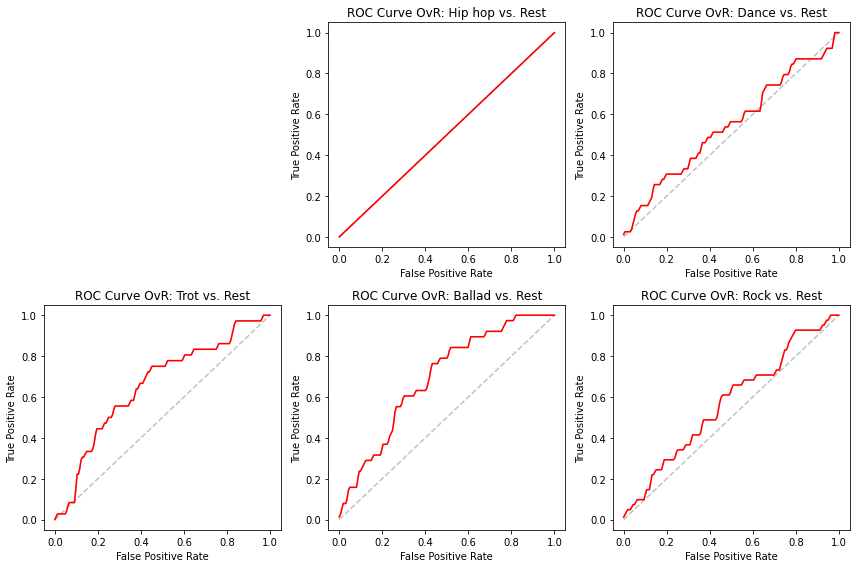

In [50]:
plt.figure(figsize = (12, 8))
roc_auc_ovr = {}
auc = []
    
for i in range(len(classes)):
    
    temptpr = []
    tempfpr = []
    
    for j in range(5):

        c = classes[i]

        df_aux = pd.DataFrame(y_test).copy()
        df_aux['class'] = [1 if y == c else 0 for y in y_test]
        df_aux['prob'] = np.array(testprob)[j][:, i]
        df_aux = df_aux.reset_index(drop = True)

        ax_bottom = plt.subplot(2, 3, i+2)
        tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])


        temptpr.append(tpr)
        tempfpr.append(fpr)
        
        plot_roc_curve_red(tpr, fpr, scatter = False, ax = ax_bottom)
        
        
        ax_bottom.set_title(f"ROC Curve OvR: {classes_names[c]} vs. Rest")

        auc.append(roc_auc_score(df_aux['class'], df_aux['prob']))
    
    temptpr = np.array(temptpr)
    tempfpr = np.array(tempfpr)
    
    num = 9 + i * 10
    prev = 9 + (i-1)*10
    plot_roc_curve_red_2(np.sort(np.array(pd.DataFrame(temptpr).mean())), np.sort(np.array(pd.DataFrame(tempfpr).mean())), scatter = False, ax = ax_bottom)

    plt.tight_layout()

In [51]:
auc[:5]

[0.5, 0.5, 0.5, 0.5, 0.5]

In [52]:
np.mean(auc[:5])

0.5

In [53]:
auc[5:10]

[0.5440356744704571,
 0.5440356744704571,
 0.5440356744704571,
 0.5440356744704571,
 0.5440356744704571]

In [54]:
np.mean(auc[5:10])

0.5440356744704571

In [55]:
auc[10:15]

[0.6554878048780488,
 0.6554878048780488,
 0.6554878048780488,
 0.6554878048780488,
 0.6554878048780488]

In [56]:
np.mean(auc[10:15])

0.6554878048780488

In [57]:
auc[15:20]

[0.6933073424301494,
 0.6933073424301494,
 0.6933073424301494,
 0.6933073424301494,
 0.6933073424301494]

In [58]:
np.mean(auc[15:20])

0.6933073424301494

In [59]:
auc[20:25]

[0.5703328731400521,
 0.5703328731400521,
 0.5703328731400521,
 0.5703328731400521,
 0.5703328731400521]

In [60]:
np.mean(auc[20:25])

0.5703328731400521

In [61]:
totalauc = [np.mean(auc[:5]), np.mean(auc[5:10]), np.mean(auc[10:15]), np.mean(auc[15:20]), np.mean(auc[20:25])]
np.mean(totalauc)

0.5926327389837415

In [62]:
from sklearn.metrics import precision_recall_fscore_support

sens0 = []
spec0 = []
sens1 = []
spec1 = []
sens2 = []
spec2 = []
sens3 = []
spec3 = []
sens4 = []
spec4 = []

for i in range(5):
    for l in [0, 1, 2, 3, 4]:
        prec, recall, _, _ = precision_recall_fscore_support(np.array(y_test) == l, testpred[i] == l, pos_label = True, average = None)
        if l == 0:
            sens0.append(recall[0])
            spec0.append(recall[1])
        elif l == 1:
            sens1.append(recall[0])
            spec1.append(recall[1])
        elif l == 2:
            sens2.append(recall[0])
            spec2.append(recall[1])
        elif l == 3:
            sens3.append(recall[0])
            spec3.append(recall[1])
        else:
            sens4.append(recall[0])
            spec4.append(recall[1])
            
df = [[np.mean(sens0), np.mean(spec0)], [np.mean(sens1), np.mean(spec1)], [np.mean(sens2), np.mean(spec2)], [np.mean(sens3), np.mean(spec3)], [np.mean(sens4), np.mean(spec4)]]
print(pd.DataFrame(df))
print(pd.DataFrame(df).mean(axis=0))

     0    1
0 1.00 0.00
1 0.76 0.33
2 0.93 0.06
3 0.67 0.61
4 0.72 0.32
0   0.81
1   0.26
dtype: float64


In [63]:
## simplernn
## lstm
## gru

## resnet50
## inception / xception
## senet (그냥...)
## vision transformer

## cosine similiarity
## p-norm


## 1. 본인 장르 30개 더
## 2. 7788 / 상준 승은 지호 지우
## 3. 지호 지우 추천시스템 (함수 만들기) - cv 모델 느낌만
## 4. 상준 승은 다 하기